In [1]:
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import pymc3 as pm
import pymc
import theano.tensor as tt

/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


ModuleNotFoundError: No module named 'pymc'

In [2]:
%matplotlib inline
plt.style.use('default')

In [3]:
matplotlib.rcParams['figure.figsize'] = (12.5,4)

In [4]:
poi = stats.poisson
lambda_ = [1.5, 4.25]
colors = ['#348ABD', '#A60628']

In [5]:
a = np.arange(16)

In [6]:
poi.pmf(5, 5)

0.17546736976785068

No handles with labels found to put in legend.


Text(0.5,0,'k')

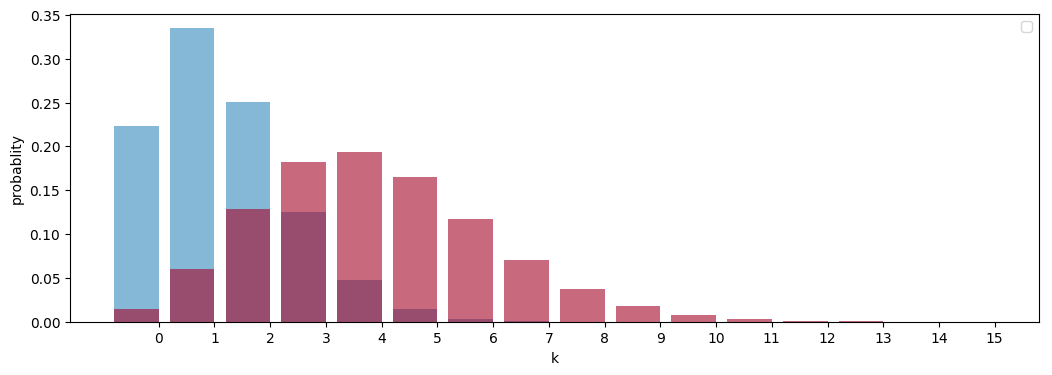

In [7]:
plt.xkcd()
plt.bar(a, poi.pmf(a, lambda_[0]), color=colors[0], alpha = 0.60)
plt.bar(a, poi.pmf(a, lambda_[1]), color=colors[1], alpha = 0.60)
plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel("probablity")
plt.xlabel("k")

In [8]:
poi.pmf(a, lambda_[0])

array([2.23130160e-01, 3.34695240e-01, 2.51021430e-01, 1.25510715e-01,
       4.70665182e-02, 1.41199554e-02, 3.52998886e-03, 7.56426185e-04,
       1.41829910e-04, 2.36383183e-05, 3.54574774e-06, 4.83511056e-07,
       6.04388819e-08, 6.97371715e-09, 7.47183980e-10, 7.47183980e-11])

In [9]:
from os import makedirs
makedirs("data", exist_ok=True)

In [10]:
from urllib.request import urlretrieve
urlretrieve("https://git.io/vXt6b", 'data/mixture_data.csv')

('data/mixture_data.csv', <http.client.HTTPMessage at 0x1140994e0>)

In [11]:
count_data = np.loadtxt('data/txtdata.csv')
n_count_data = len(count_data)

(0, 74)

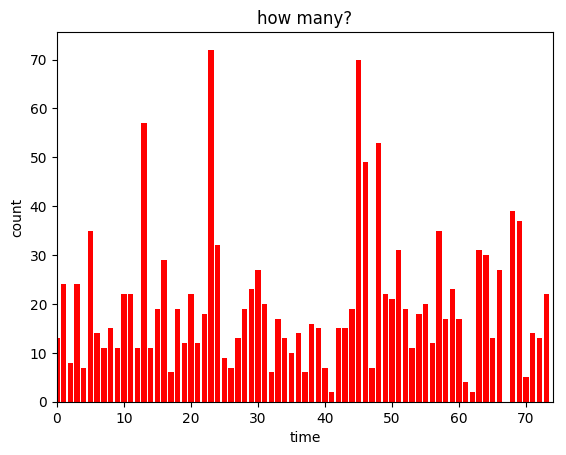

In [12]:
plt.style.use('default')
plt.bar(np.arange(n_count_data), count_data, color="red")

plt.xlabel('time')
plt.ylabel('count')
plt.title('how many?')
plt.xlim(0, n_count_data)

In [13]:
alpha = 1.0 / count_data.mean()

In [14]:
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

In [15]:
tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

In [16]:
@pm.deterministic
def lambda_(tau=tau, lambada_1=lambda_2, lambada_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

AttributeError: module 'pymc3' has no attribute 'deterministic'

In [17]:
observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)
model = pm.Model([observation, lambda_1, lambda_2, tau])

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

In [18]:
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)

AttributeError: module 'pymc3' has no attribute 'MCMC'

In [19]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

NameError: name 'mcmc' is not defined

In [20]:
tau_samples

NameError: name 'tau_samples' is not defined

NameError: name 'lambda_1_samples' is not defined

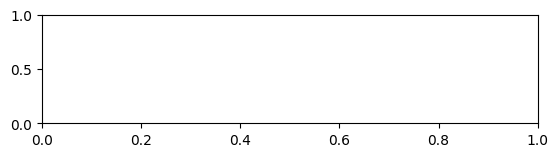

In [21]:
ax = plt.subplot(311)
ax.set_autoscaley_on(True)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability")

In [22]:
with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

In [ ]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

In [ ]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [ ]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

In [ ]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

In [ ]:
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability")

In [ ]:
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left")

In [ ]:
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1)
    data_generator = pm.Poisson("data_generator", parameter)

In [4]:
with model:
    data_plus_one = data_generator + 1

In [8]:
parameter.tag.test_value

array(0.693147177890573)

In [9]:
with pm.Model() as model:
    theta = pm.Exponential("theta", 2)
    data_generator = pm.Poisson("data_generator", theta)

In [11]:
with pm.Model() as ab_testing:
    p_A = pm.Uniform("P(A)", 0, 1)
    p_B = pm.Uniform("P(B)", 0, 1)

In [15]:
data_generator.tag.test_value

0

In [31]:
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1, testval=0.7)

In [32]:
parameter.tag.test_value

array(0.7)

In [33]:
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1)
    lambda_2 = pm.Exponential("lambda_2", 1)
    tau = pm.DiscreteUniform("tau", lower=0, upper=10)

new_deterministic_variable = lambda_1 + lambda_2

In [34]:
new_deterministic_variable

Elemwise{add,no_inplace}.0

In [48]:
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

In [36]:
p_true = 0.05  # remember, this is unknown.
N = 1500

In [37]:
occurrences = stats.bernoulli.rvs(p_true, size=N)

In [42]:
np.mean(occurrences)

0.052666666666666667

In [49]:
with model:
    obs = pm.Bernoulli("obs", p, observed=occurrences)
    # To be explained in chapter 3
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

100%|██████████| 18000/18000 [00:01<00:00, 13487.12it/s]


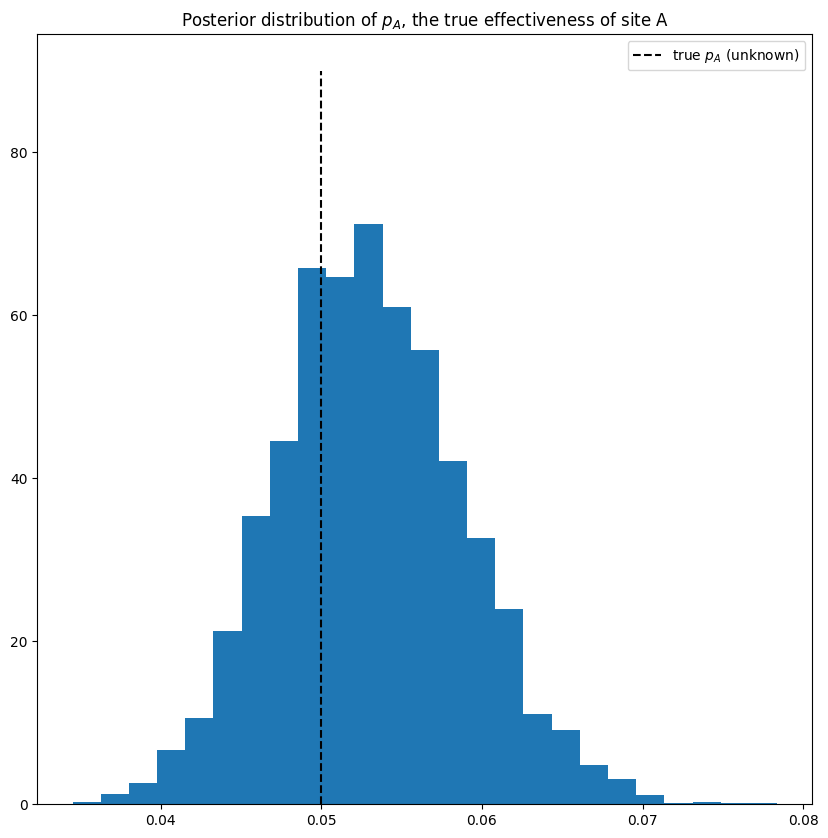

In [50]:
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", normed=True)
plt.legend()

In [60]:
true_p_A = 0.05
true_p_B = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)

In [62]:
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(200000, step=step)
    burned_trace=trace[1000:]

100%|██████████| 200000/200000 [00:26<00:00, 7588.74it/s]


In [63]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

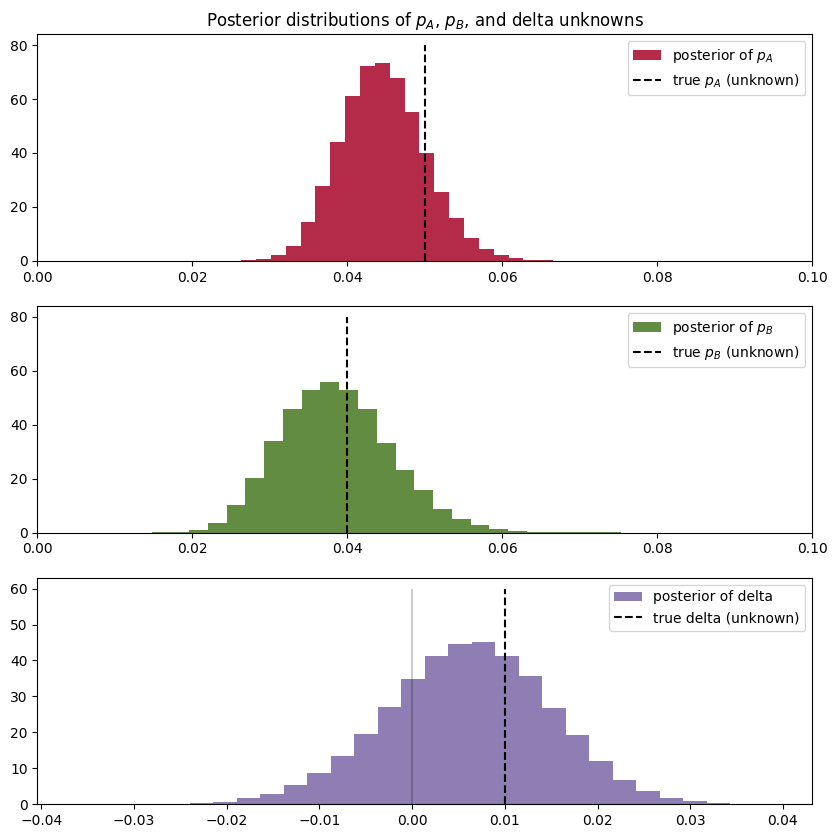

In [64]:
ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right")

In [67]:
"Probability site A is WORSE than site B: %.3f" % np.mean(delta_samples < 0)

'Probability site A is WORSE than site B: 0.242'

In [68]:
"Probability site A is BETTER than site B: %.3f" % np.mean(delta_samples > 0)

'Probability site A is BETTER than site B: 0.758'

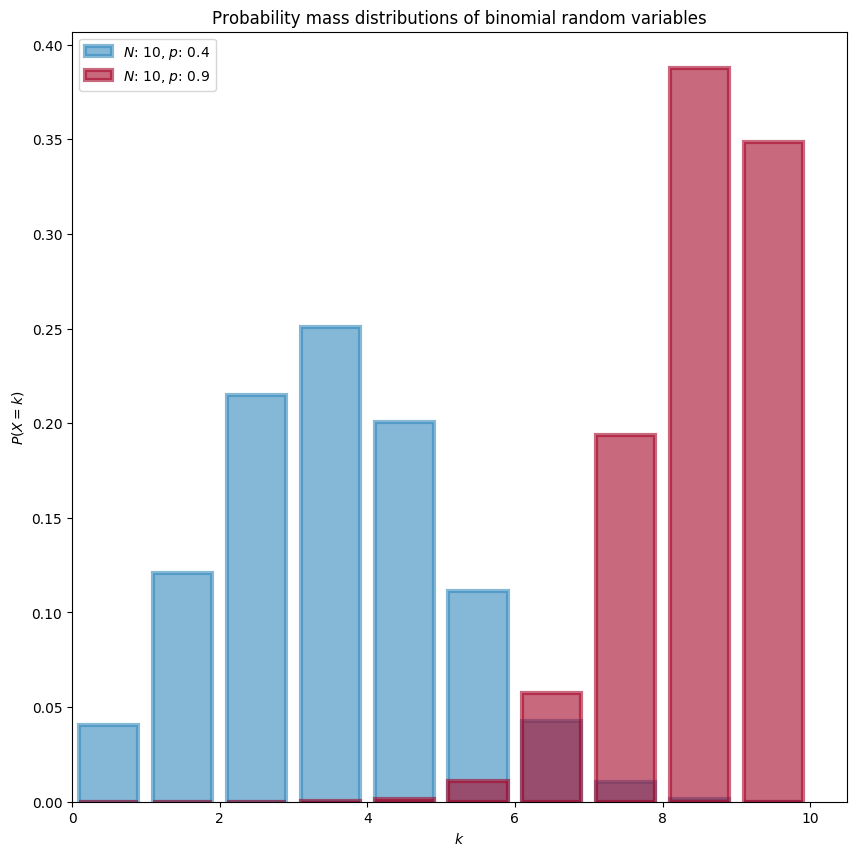

In [71]:
binomial = stats.binom

parameters = [(10, .4), (10, .9)]
colors = ["#348ABD", "#A60628"]

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N + 1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i],
            edgecolor=colors[i],
            alpha=0.6,
            label="$N$: %d, $p$: %.1f" % (N, p),
            linewidth=3)

plt.legend(loc="upper left")
plt.xlim(0, 10.5)
plt.xlabel("$k$")
plt.ylabel("$P(X = k)$")
plt.title("Probability mass distributions of binomial random variables")

In [80]:
N = 100
with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)

In [81]:
with model:
    true_answers = pm.Bernoulli("truths", p, shape=N, testval=np.random.binomial(1, 0.5, N))

In [84]:
with model:
    first_coin_flips = pm.Bernoulli("first_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))

In [85]:
with model:
    second_coin_flips = pm.Bernoulli("second_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))

In [86]:
with model:
    val = first_coin_flips*true_answers + (1 - first_coin_flips)*second_coin_flips
    observed_proportion = pm.Deterministic("observed_proportion", tt.sum(val)/float(N))

In [87]:
observed_proportion.tag.test_value

array(0.4699999988079071)

In [88]:
X = 35

with model:
    observations = pm.Binomial("obs", N, observed_proportion, observed=X)

In [89]:
with model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

Assigned BinaryGibbsMetropolis to truths
Assigned BinaryGibbsMetropolis to first_flips
Assigned BinaryGibbsMetropolis to second_flips
100%|██████████| 40000/40000 [13:37<00:00, 48.91it/s]


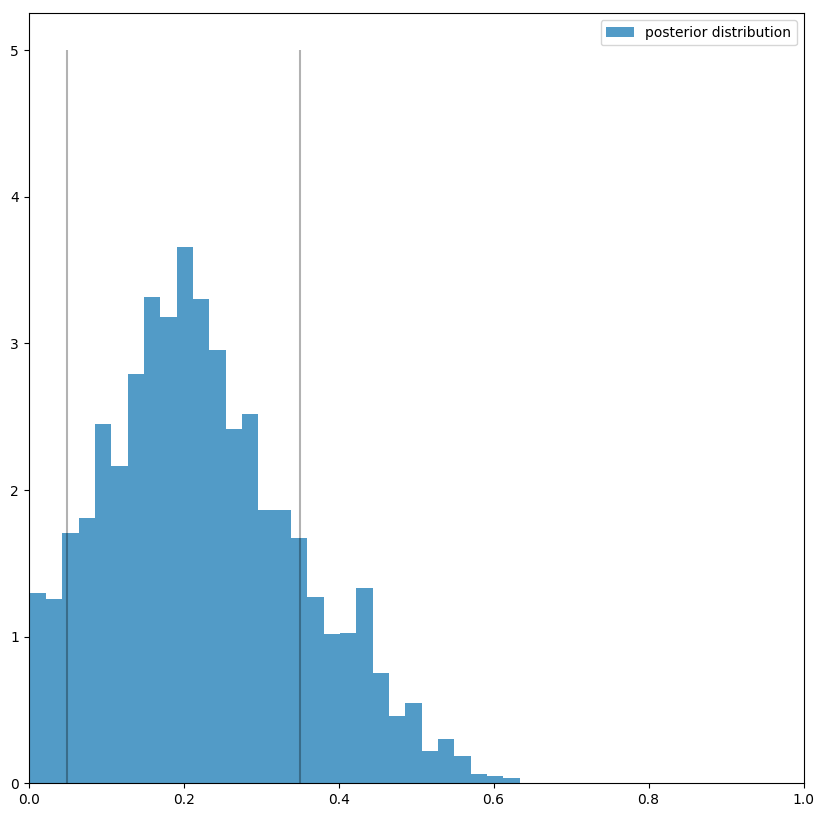

In [90]:
p_trace = burned_trace["freq_cheating"][15000:]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

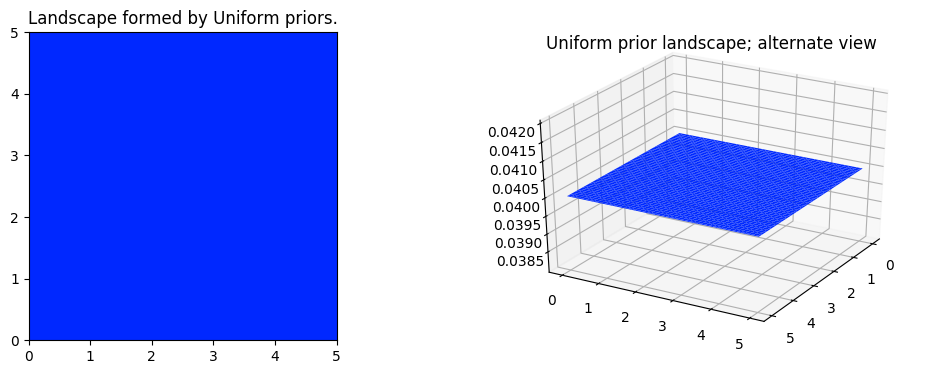

In [98]:
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Uniform prior landscape; alternate view")

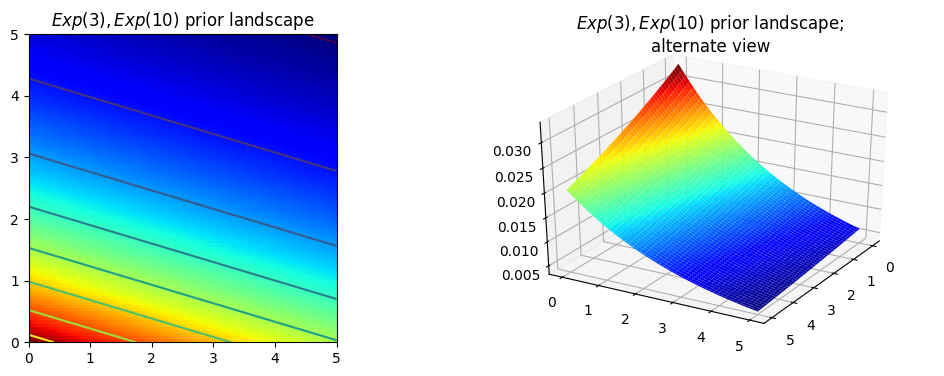

In [97]:
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
#plt.xlabel("prior on $p_1$")
#plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view");

(0, 42.0)

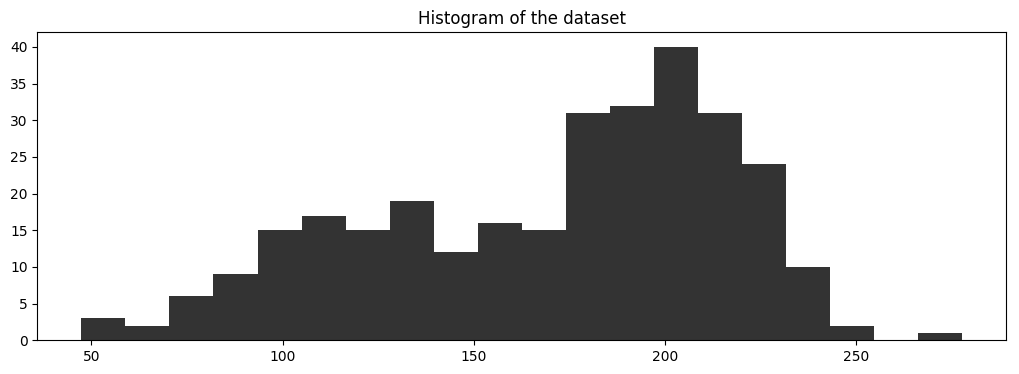

In [100]:
data = np.loadtxt("data/mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None])

In [103]:
with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    assignment = pm.Categorical("assignment", p, 
                                shape=data.shape[0],
                                testval=np.random.randint(0, 2, data.shape[0]))

In [104]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([120, 190]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)

In [105]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2])

/Users/ikedayutaro/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  app.launch_new_instance()
100%|██████████| 25000/25000 [01:20<00:00, 309.00it/s]


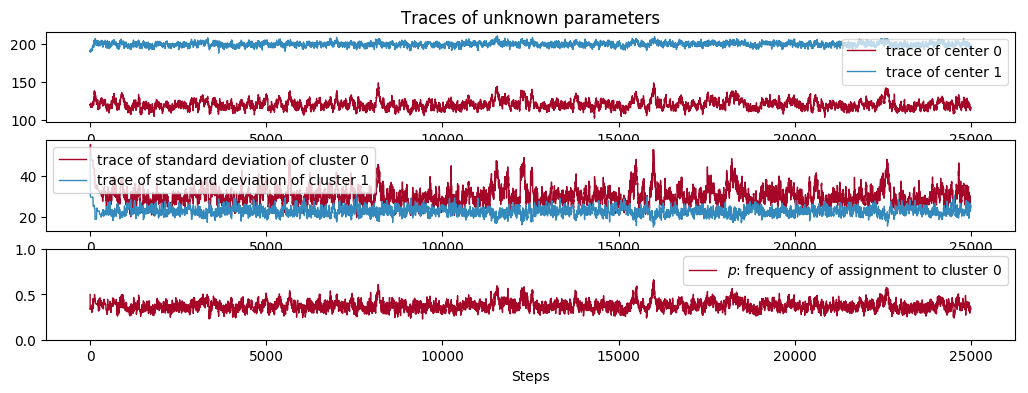

In [106]:
plt.subplot(311)
lw = 1
center_trace = trace["centers"]

# for pretty colors later in the book.
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend()

In [107]:
with model:
    trace = pm.sample(50000, step=[step1, step2], trace=trace)

100%|██████████| 50000/50000 [02:43<00:00, 306.32it/s]


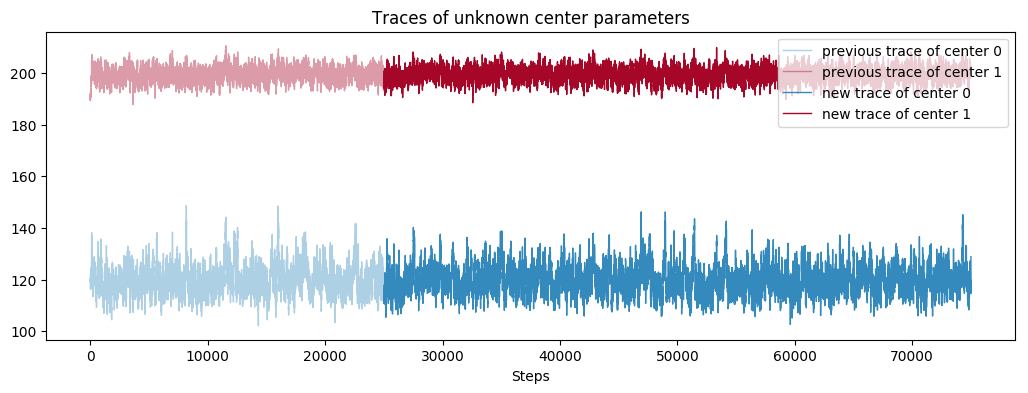

In [108]:
center_trace = trace["centers"][25000:]
prev_center_trace = trace["centers"][:25000]

x = np.arange(25000)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(25000, 75000)
plt.plot(x, center_trace[:, 0], label="new trace of center 0", lw=lw, c="#348ABD")
plt.plot(x, center_trace[:, 1], label="new trace of center 1", lw=lw, c="#A60628")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps")